# XGBoost Model Training on Raw Feature-Engineered Data
## GoBest Cab - Dangerous Driving Behaviour Detection

This notebook implements XGBoost classifier (the best performing model) on the raw feature-engineered dataset
(`fact_trip_safety.csv`) for comparison with the SMOTE-balanced dataset results.

**Purpose**: Compare model performance between:
- Raw feature-engineered data (this notebook)
- SMOTE-balanced data (xgboost_training_ablation.ipynb)

Features:
- MLflow experiment tracking
- Class imbalance handling (without SMOTE)
- Regularization techniques
- Hyperparameter tuning

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from xgboost import XGBClassifier

# MLflow
import mlflow
import mlflow.xgboost
from mlflow.models.signature import infer_signature

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. MLflow Setup

In [2]:
# MLflow Configuration
mlflow.set_tracking_uri("http://localhost:5000")

# Define experiment naming convention
EXPERIMENT_BASE_NAME = "XGBoost_raw_feature_engineered"

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: http://localhost:5000


## 2. Load Data

In [3]:
# Load the raw feature-engineered dataset
DATA_PATH = "../../Datasets/feature_engineered_datasets/fact_trip_safety.csv"

df = pd.read_csv(DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
df.head()

Dataset shape: (19972, 20)

Column names:
['booking_id', 'driver_id', 'vehicle_key', 'driving_exp_band', 'acceleration_profile', 'braking_profile', 'turning_profile', 'speed_profile', 'combined_risk_level', 'is_dangerous_trip', 'trip_duration_sec', 'total_distance_km', 'avg_gps_accuracy', 'harsh_acceleration_count', 'harsh_braking_count', 'sharp_turn_count', 'speeding_event_count', 'phone_distraction_count', 'avg_acceleration_magnitude', 'max_acceleration_magnitude']

First few rows:


,booking_id,driver_id,vehicle_key,driving_exp_band,acceleration_profile,braking_profile,turning_profile,speed_profile,combined_risk_level,is_dangerous_trip,trip_duration_sec,total_distance_km,avg_gps_accuracy,harsh_acceleration_count,harsh_braking_count,sharp_turn_count,speeding_event_count,phone_distraction_count,avg_acceleration_magnitude,max_acceleration_magnitude
0,0,359,98.0,6-10,Low,Low,Low,Low,Low,False,1589.0,4.089244,9.787946,1,0,0,0,0,9.865861,12.258996
1,1,313,220.0,21+,Low,Low,Medium,Low,Medium,True,1034.0,2.999237,3.703376,0,0,3,0,0,9.864575,11.844354
2,2,27,26.0,21+,Low,Low,Low,Low,Low,True,822.0,0.231004,3.821759,0,0,0,0,0,9.816216,11.051480
3,4,164,239.0,21+,Low,Low,Low,Low,Low,True,1092.0,2.921325,10.000000,0,0,0,0,0,9.794901,13.493185
4,6,118,NaN,16-20,Low,Low,Low,Low,Low,False,1092.0,2.427733,4.631772,2,0,2,0,0,9.897687,13.393135


In [4]:
# Check target variable
print("Target variable (is_dangerous_trip) info:")
print(f"Data type: {df['is_dangerous_trip'].dtype}")
print(f"\nValue counts:")
print(df['is_dangerous_trip'].value_counts())
print(f"\nClass distribution (percentage):")
print(df['is_dangerous_trip'].value_counts(normalize=True))

Target variable (is_dangerous_trip) info:
Data type: bool

Value counts:
is_dangerous_trip
False    14994
True      4978
Name: count, dtype: int64

Class distribution (percentage):
is_dangerous_trip
False    0.750751
True     0.249249
Name: proportion, dtype: float64


In [5]:
# Convert boolean target to integer (0/1)
df['label'] = df['is_dangerous_trip'].map({False: 0, True: 1, 'false': 0, 'true': 1})

# If still has issues, try this
if df['label'].isna().any():
    df['label'] = df['is_dangerous_trip'].astype(str).str.lower().map({'false': 0, 'true': 1})

print("Label distribution:")
print(df['label'].value_counts())

# Calculate class imbalance ratio
class_counts = df['label'].value_counts()
imbalance_ratio = class_counts[0] / class_counts[1] if 1 in class_counts.index else 1
print(f"\nClass imbalance ratio (0:1): {imbalance_ratio:.2f}:1")

Label distribution:
label
0    14994
1     4978
Name: count, dtype: int64

Class imbalance ratio (0:1): 3.01:1


## 3. Data Preprocessing

In [6]:
# Identify columns to drop (IDs and target-related)
columns_to_drop = ['booking_id', 'driver_id', 'vehicle_key', 'is_dangerous_trip', 'label']

# Identify categorical columns that need encoding
categorical_cols = ['driving_exp_band', 'acceleration_profile', 'braking_profile', 
                    'turning_profile', 'speed_profile', 'combined_risk_level']

print("Categorical columns to encode:")
for col in categorical_cols:
    if col in df.columns:
        print(f"  {col}: {df[col].unique()}")

Categorical columns to encode:
  driving_exp_band: ['6-10' '21+' '16-20' '11-15' '0-5']
  acceleration_profile: ['Low' 'Medium' 'Extreme' 'High']
  braking_profile: ['Low' 'Extreme' 'Medium' 'High']
  turning_profile: ['Low' 'Medium' 'High' 'Extreme']
  speed_profile: ['Low' 'Extreme' 'High' 'Medium']
  combined_risk_level: ['Low' 'Medium' 'Extreme' 'High']


In [7]:
# Encode categorical variables using Label Encoding
label_encoders = {}
df_encoded = df.copy()

for col in categorical_cols:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, range(len(le.classes_))))}")

print(f"\nEncoded dataset shape: {df_encoded.shape}")

Encoded driving_exp_band: {'0-5': 0, '11-15': 1, '16-20': 2, '21+': 3, '6-10': 4}
Encoded acceleration_profile: {'Extreme': 0, 'High': 1, 'Low': 2, 'Medium': 3}
Encoded braking_profile: {'Extreme': 0, 'High': 1, 'Low': 2, 'Medium': 3}
Encoded turning_profile: {'Extreme': 0, 'High': 1, 'Low': 2, 'Medium': 3}
Encoded speed_profile: {'Extreme': 0, 'High': 1, 'Low': 2, 'Medium': 3}
Encoded combined_risk_level: {'Extreme': 0, 'High': 1, 'Low': 2, 'Medium': 3}

Encoded dataset shape: (19972, 21)


In [8]:
# Prepare features and target
X = df_encoded.drop(columns=columns_to_drop, errors='ignore')
y = df_encoded['label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist())

Features shape: (19972, 16)
Target shape: (19972,)

Feature columns (16):
['driving_exp_band', 'acceleration_profile', 'braking_profile', 'turning_profile', 'speed_profile', 'combined_risk_level', 'trip_duration_sec', 'total_distance_km', 'avg_gps_accuracy', 'harsh_acceleration_count', 'harsh_braking_count', 'sharp_turn_count', 'speeding_event_count', 'phone_distraction_count', 'avg_acceleration_magnitude', 'max_acceleration_magnitude']


In [9]:
# Check for missing values and handle them
print("Missing values per column:")
missing = X.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found.")

# Check for infinite values
inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
print(f"\nInfinite values count: {inf_count}")
if inf_count > 0:
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Infinite values replaced with median.")

Missing values per column:
No missing values found.

Infinite values count: 0


In [10]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training set: 15977 samples
Test set: 3995 samples

Training class distribution:
label
0    0.750767
1    0.249233
Name: proportion, dtype: float64

Test class distribution:
label
0    0.750688
1    0.249312
Name: proportion, dtype: float64


In [11]:
# Feature scaling using RobustScaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print("Feature scaling completed using RobustScaler.")

Feature scaling completed using RobustScaler.


## 4. Class Imbalance Handling

In [12]:
# Calculate scale_pos_weight for class imbalance
# This is the ratio of negative class to positive class
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"Negative class (0) count: {neg_count}")
print(f"Positive class (1) count: {pos_count}")
print(f"Scale pos weight: {scale_pos_weight:.4f}")

# Class weight dictionary for reference
class_weight_dict = {
    0: 1.0,
    1: scale_pos_weight
}
print(f"\nClass weight dictionary: {class_weight_dict}")

Negative class (0) count: 11995
Positive class (1) count: 3982
Scale pos weight: 3.0123

Class weight dictionary: {0: 1.0, 1: np.float64(3.012305374183827)}


## 5. Helper Functions

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with all required metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba),
    }
    
    # Detect overfitting
    overfit_gap = metrics['train_f1'] - metrics['test_f1']
    metrics['overfit_gap'] = overfit_gap
    metrics['is_overfitting'] = overfit_gap > 0.05
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"\nAccuracy  - Train: {metrics['train_accuracy']:.4f} | Test: {metrics['test_accuracy']:.4f}")
    print(f"F1 Score  - Train: {metrics['train_f1']:.4f} | Test: {metrics['test_f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\nOverfit Gap (Train F1 - Test F1): {overfit_gap:.4f}")
    if metrics['is_overfitting']:
        print("⚠️  WARNING: Model shows signs of overfitting!")
    else:
        print("✅ Model generalization looks good.")
    
    return metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """Plot confusion matrix."""
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe (0)', 'Dangerous (1)'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    return fig


def plot_roc_curve(y_test, y_proba, model_name="Model"):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve')
    ax.legend(loc='lower right')
    plt.tight_layout()
    return fig


def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """Plot top N feature importances."""
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(top_n), importance[indices][::-1], align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([feature_names[i] for i in indices][::-1])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'{model_name} - Top {top_n} Feature Importances')
    plt.tight_layout()
    return fig


def plot_learning_history(evals_result, model_name="Model"):
    """Plot XGBoost learning history."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    epochs = len(evals_result['train']['logloss'])
    x_axis = range(1, epochs + 1)
    
    ax.plot(x_axis, evals_result['train']['logloss'], 'b-', label='Train Loss', linewidth=2)
    ax.plot(x_axis, evals_result['validation']['logloss'], 'r-', label='Validation Loss', linewidth=2)
    
    ax.set_xlabel('Boosting Iterations')
    ax.set_ylabel('Log Loss')
    ax.set_title(f'{model_name} - Learning History')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

## 6. Cross-Validation Setup

In [14]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def perform_cross_validation(model, X, y, cv=cv):
    """Perform cross-validation and return scores."""
    scoring = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
    print("\nCross-Validation Results (5-fold):")
    print("-" * 50)
    for metric in scoring:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        print(f"{metric.upper():12} - Train: {train_scores.mean():.4f} (+/- {train_scores.std()*2:.4f}) | "
              f"Test: {test_scores.mean():.4f} (+/- {test_scores.std()*2:.4f})")
    
    return cv_results

---
## 7. Model Training WITHOUT Regularization
### Baseline XGBoost Model (High Complexity, No Regularization)

In [15]:
# Set experiment for no regularization
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_noreg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_noreg")

2026/02/02 00:24:51 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_raw_feature_engineered_noreg' does not exist. Creating a new experiment.


Experiment: XGBoost_raw_feature_engineered_noreg


In [16]:
# XGBoost WITHOUT Regularization (baseline)
xgb_noreg = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    min_child_weight=1,
    gamma=0,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("XGBoost Model (No Regularization) Configuration:")
print(xgb_noreg.get_params())

XGBoost Model (No Regularization) Configuration:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': np.float64(3.012305374183827), 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Training XGBoost without regularization...

XGBoost Raw (No Regularization) Evaluation Results

Accuracy  - Train: 0.9435 | Test: 0.7029
F1 Score  - Train: 0.8915 | Test: 0.4350
Precision: 0.4136
Recall:    0.4588
ROC-AUC:   0.6781

Overfit Gap (Train F1 - Test F1): 0.4565
⚠️  WARNING: Model shows signs of overfitting!


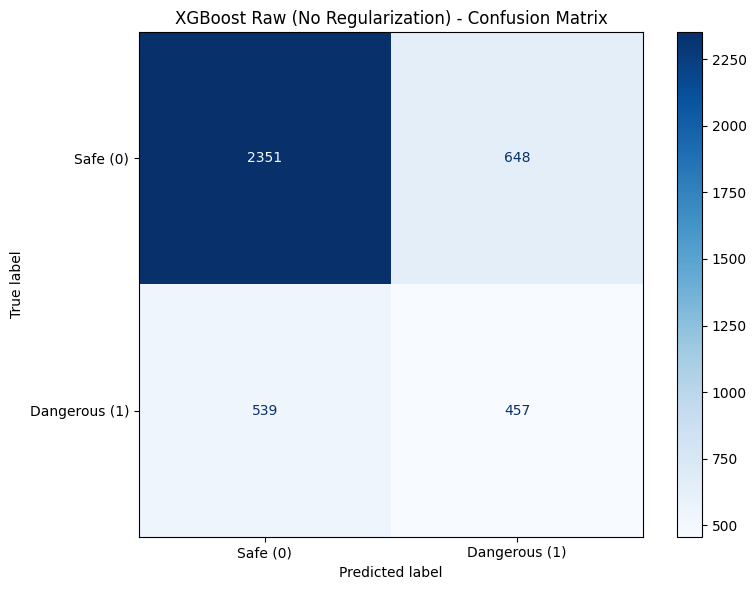

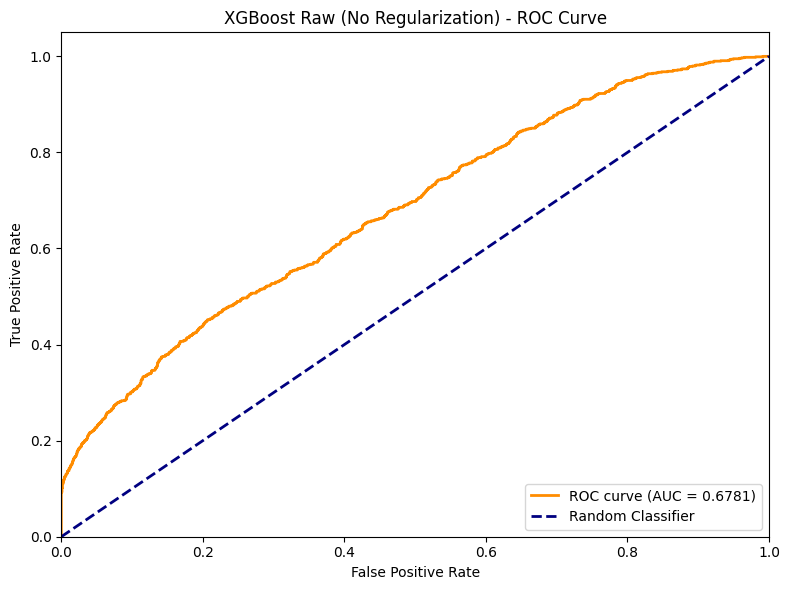

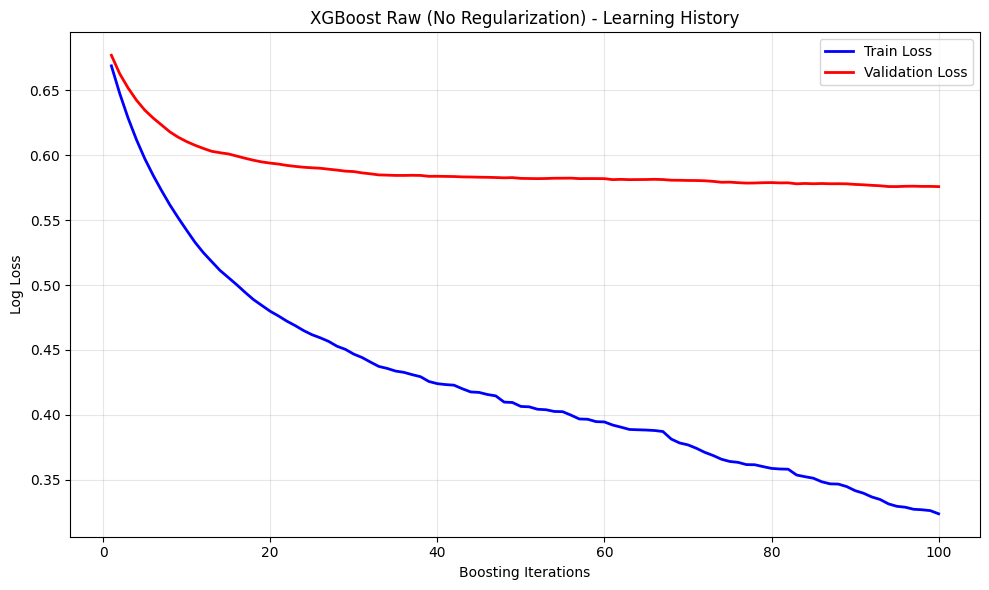

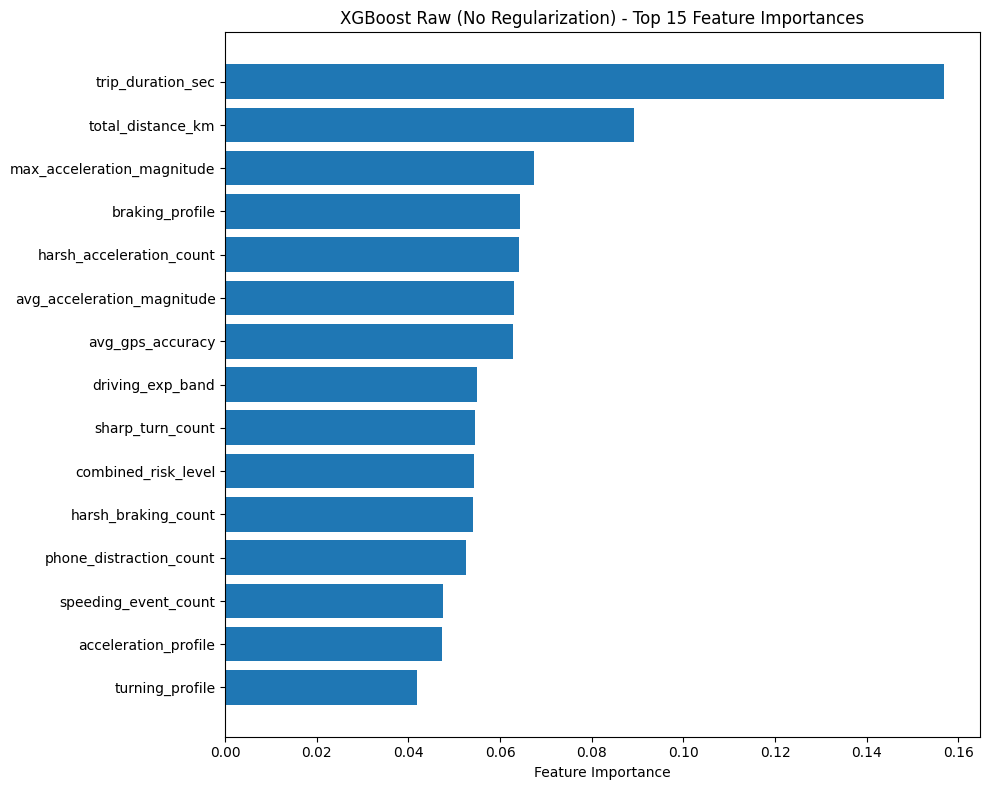

2026/02/02 00:24:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: e9f7d8a4207e46c7b207b9d6e700e66f
🏃 View run XGBoost_Raw_NoReg_Baseline at: http://localhost:5000/#/experiments/23/runs/e9f7d8a4207e46c7b207b9d6e700e66f
🧪 View experiment at: http://localhost:5000/#/experiments/23


In [17]:
# Train the model without regularization
with mlflow.start_run(run_name="XGBoost_Raw_NoReg_Baseline"):
    # Log parameters
    mlflow.log_params(xgb_noreg.get_params())
    mlflow.log_param("regularization", "none")
    mlflow.log_param("dataset", "raw_feature_engineered")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model
    print("Training XGBoost without regularization...")
    xgb_noreg.fit(X_train_scaled, y_train, 
                  eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], 
                  verbose=False)
    evals_result_noreg = xgb_noreg.evals_result()
    
    # Evaluate
    metrics_noreg, y_pred_noreg, y_proba_noreg = evaluate_model(
        xgb_noreg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="XGBoost Raw (No Regularization)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_noreg['train_accuracy'],
        'test_accuracy': metrics_noreg['test_accuracy'],
        'train_f1': metrics_noreg['train_f1'],
        'test_f1': metrics_noreg['test_f1'],
        'precision': metrics_noreg['precision'],
        'recall': metrics_noreg['recall'],
        'roc_auc': metrics_noreg['roc_auc'],
        'overfit_gap': metrics_noreg['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_noreg, "XGBoost Raw (No Regularization)")
    mlflow.log_figure(fig_cm, "confusion_matrix_noreg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_noreg, "XGBoost Raw (No Regularization)")
    mlflow.log_figure(fig_roc, "roc_curve_noreg.png")
    plt.show()
    
    # Plot and log learning history
    fig_lh = plot_learning_history({'train': evals_result_noreg['validation_0'], 
                                    'validation': evals_result_noreg['validation_1']}, 
                                   "XGBoost Raw (No Regularization)")
    mlflow.log_figure(fig_lh, "learning_history_noreg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(xgb_noreg, X_train_scaled.columns.tolist(), top_n=15, 
                                     model_name="XGBoost Raw (No Regularization)")
    mlflow.log_figure(fig_fi, "feature_importance_noreg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.xgboost.log_model(xgb_noreg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [18]:
# Cross-validation for no-reg model
print("\n" + "="*60)
print("Cross-Validation for XGBoost Raw (No Regularization)")
print("="*60)
cv_results_noreg = perform_cross_validation(xgb_noreg, X_train_scaled, y_train)


Cross-Validation for XGBoost Raw (No Regularization)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.9142 (+/- 0.0104) | Test: 0.4307 (+/- 0.0283)
PRECISION    - Train: 0.8845 (+/- 0.0162) | Test: 0.4238 (+/- 0.0354)
RECALL       - Train: 0.9461 (+/- 0.0098) | Test: 0.4380 (+/- 0.0228)
ROC_AUC      - Train: 0.9922 (+/- 0.0017) | Test: 0.6869 (+/- 0.0180)
ACCURACY     - Train: 0.9557 (+/- 0.0057) | Test: 0.7113 (+/- 0.0194)


In [19]:
# Classification Report
print("\nClassification Report (No Regularization):")
print(classification_report(y_test, y_pred_noreg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (No Regularization):
               precision    recall  f1-score   support

     Safe (0)       0.81      0.78      0.80      2999
Dangerous (1)       0.41      0.46      0.44       996

     accuracy                           0.70      3995
    macro avg       0.61      0.62      0.62      3995
 weighted avg       0.71      0.70      0.71      3995



---
## 8. Model Training WITH Regularization
### XGBoost with Regularization to Combat Overfitting

In [20]:
# Set experiment for regularized model
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_reg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_reg")

2026/02/02 00:25:00 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_raw_feature_engineered_reg' does not exist. Creating a new experiment.


Experiment: XGBoost_raw_feature_engineered_reg


In [21]:
# XGBoost WITH Regularization
xgb_reg = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("XGBoost Model (With Regularization) Configuration:")
print("\nRegularization techniques applied:")
print("- Reduced max_depth: 10 -> 6")
print("- Lower learning_rate: 0.1 -> 0.05")
print("- Increased min_child_weight: 1 -> 5")
print("- Added gamma: 0 -> 0.1")
print("- Subsampling: 1.0 -> 0.8")
print("- Column sampling: 1.0 -> 0.8")
print("- L1 regularization (reg_alpha): 0 -> 0.1")

XGBoost Model (With Regularization) Configuration:

Regularization techniques applied:
- Reduced max_depth: 10 -> 6
- Lower learning_rate: 0.1 -> 0.05
- Increased min_child_weight: 1 -> 5
- Added gamma: 0 -> 0.1
- Subsampling: 1.0 -> 0.8
- Column sampling: 1.0 -> 0.8
- L1 regularization (reg_alpha): 0 -> 0.1


Training XGBoost with regularization...

XGBoost Raw (Regularized) Evaluation Results

Accuracy  - Train: 0.7879 | Test: 0.6706
F1 Score  - Train: 0.6394 | Test: 0.4503
Precision: 0.3856
Recall:    0.5412
ROC-AUC:   0.6984

Overfit Gap (Train F1 - Test F1): 0.1891
⚠️  WARNING: Model shows signs of overfitting!


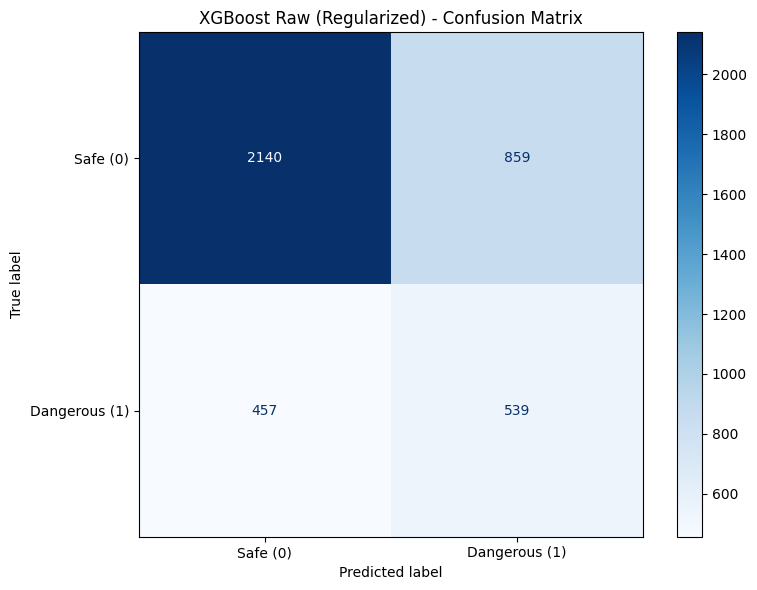

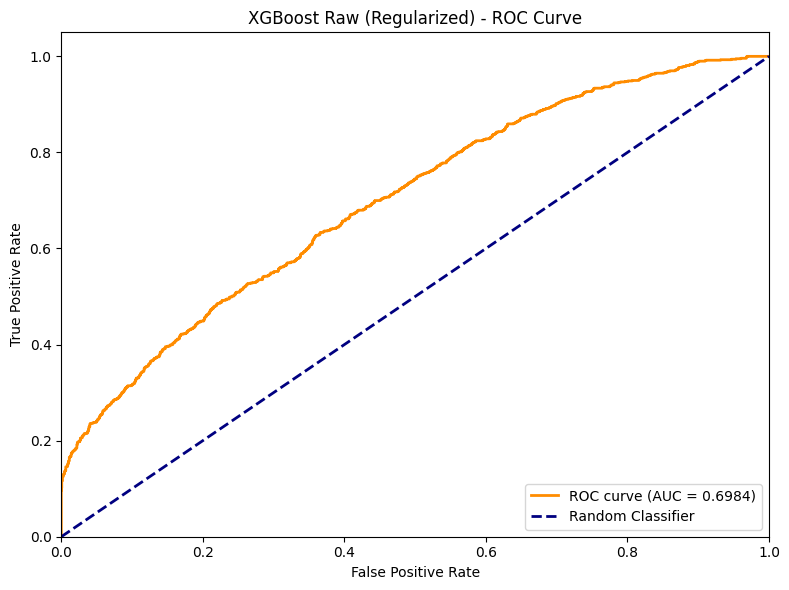

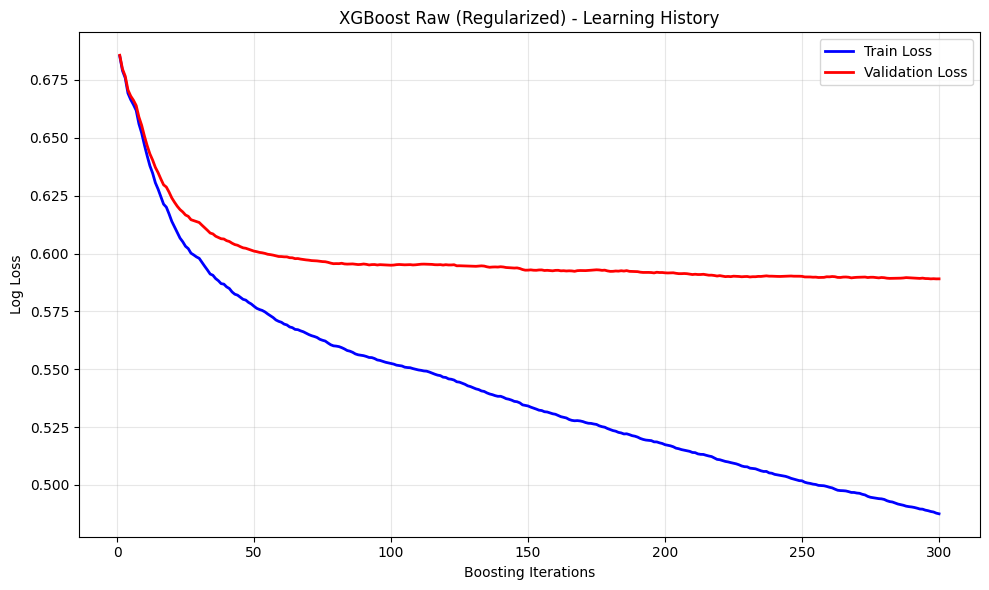

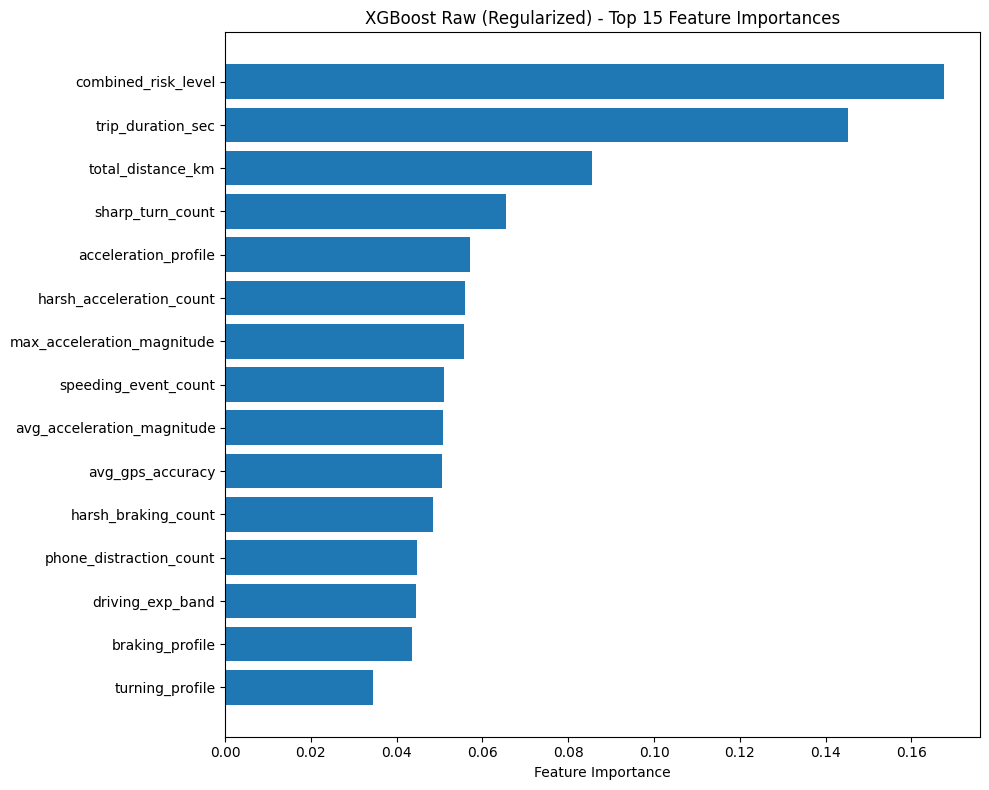

2026/02/02 00:25:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: b2612b16bd0140729f1f958327b070ca
🏃 View run XGBoost_Raw_Regularized at: http://localhost:5000/#/experiments/24/runs/b2612b16bd0140729f1f958327b070ca
🧪 View experiment at: http://localhost:5000/#/experiments/24


In [22]:
# Train the model with regularization
with mlflow.start_run(run_name="XGBoost_Raw_Regularized"):
    # Log parameters
    mlflow.log_params(xgb_reg.get_params())
    mlflow.log_param("regularization", "L1_L2_dropout")
    mlflow.log_param("dataset", "raw_feature_engineered")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model
    print("Training XGBoost with regularization...")
    xgb_reg.fit(X_train_scaled, y_train, 
                eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], 
                verbose=False)
    evals_result_reg = xgb_reg.evals_result()
    
    # Evaluate
    metrics_reg, y_pred_reg, y_proba_reg = evaluate_model(
        xgb_reg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="XGBoost Raw (Regularized)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_reg['train_accuracy'],
        'test_accuracy': metrics_reg['test_accuracy'],
        'train_f1': metrics_reg['train_f1'],
        'test_f1': metrics_reg['test_f1'],
        'precision': metrics_reg['precision'],
        'recall': metrics_reg['recall'],
        'roc_auc': metrics_reg['roc_auc'],
        'overfit_gap': metrics_reg['overfit_gap']
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_reg, "XGBoost Raw (Regularized)")
    mlflow.log_figure(fig_cm, "confusion_matrix_reg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_reg, "XGBoost Raw (Regularized)")
    mlflow.log_figure(fig_roc, "roc_curve_reg.png")
    plt.show()
    
    # Plot and log learning history
    fig_lh = plot_learning_history({'train': evals_result_reg['validation_0'], 
                                    'validation': evals_result_reg['validation_1']}, 
                                   "XGBoost Raw (Regularized)")
    mlflow.log_figure(fig_lh, "learning_history_reg.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(xgb_reg, X_train_scaled.columns.tolist(), top_n=15, 
                                     model_name="XGBoost Raw (Regularized)")
    mlflow.log_figure(fig_fi, "feature_importance_reg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.xgboost.log_model(xgb_reg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [23]:
# Cross-validation for regularized model
print("\n" + "="*60)
print("Cross-Validation for XGBoost Raw (Regularized)")
print("="*60)
cv_results_reg = perform_cross_validation(xgb_reg, X_train_scaled, y_train)


Cross-Validation for XGBoost Raw (Regularized)

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.6696 (+/- 0.0041) | Test: 0.4626 (+/- 0.0323)
PRECISION    - Train: 0.5851 (+/- 0.0081) | Test: 0.4049 (+/- 0.0364)
RECALL       - Train: 0.7828 (+/- 0.0122) | Test: 0.5397 (+/- 0.0254)
ROC_AUC      - Train: 0.8886 (+/- 0.0027) | Test: 0.7051 (+/- 0.0187)
ACCURACY     - Train: 0.8075 (+/- 0.0041) | Test: 0.6872 (+/- 0.0270)


In [24]:
# Classification Report
print("\nClassification Report (Regularized):")
print(classification_report(y_test, y_pred_reg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Regularized):
               precision    recall  f1-score   support

     Safe (0)       0.82      0.71      0.76      2999
Dangerous (1)       0.39      0.54      0.45       996

     accuracy                           0.67      3995
    macro avg       0.60      0.63      0.61      3995
 weighted avg       0.71      0.67      0.69      3995



---
## 9. Hyperparameter Tuning
### RandomizedSearchCV for Optimal Parameters

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import time

# Determine best base model for tuning
base_models = {
    'noreg': (xgb_noreg, metrics_noreg, 'No Regularization'),
    'reg': (xgb_reg, metrics_reg, 'Regularized')
}

best_base_name = max(base_models.keys(), key=lambda k: base_models[k][1]['test_f1'])
best_base_model, best_base_metrics, best_base_label = base_models[best_base_name]

print(f"Best base model for tuning: XGBoost ({best_base_label})")
print(f"Current Test F1: {best_base_metrics['test_f1']:.4f}")
print(f"Current Overfit Gap: {best_base_metrics['overfit_gap']:.4f}")

Best base model for tuning: XGBoost (Regularized)
Current Test F1: 0.4503
Current Overfit Gap: 0.1891


In [26]:
# Define hyperparameter search space
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.19),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.5, 1.5)
}

# Create base model for tuning
xgb_tune = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Hyperparameter Search Space:")
for param, dist in param_distributions.items():
    print(f"  {param}: {dist}")

Hyperparameter Search Space:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000248935A3310>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002489322FC10>
  learning_rate: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024893587EE0>
  min_child_weight: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002489322EC20>
  gamma: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000248937A7580>
  subsample: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002489322CA60>
  colsample_bytree: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024890A8F580>
  reg_alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000248FEA7C970>
  reg_lambda: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000248937BC520>


In [27]:
# Set experiment for hyperparameter tuning
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_tuned")

# Perform randomized search
print("\nStarting Hyperparameter Tuning (this may take several minutes)...")
print("="*60)

start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=xgb_tune,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)

tuning_time = time.time() - start_time
print(f"\nTuning completed in {tuning_time/60:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 Score: {random_search.best_score_:.4f}")

2026/02/02 00:25:07 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_raw_feature_engineered_tuned' does not exist. Creating a new experiment.



Starting Hyperparameter Tuning (this may take several minutes)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Tuning completed in 0.18 minutes

Best parameters found:
  colsample_bytree: 0.7996773519539009
  gamma: 0.17160125976275492
  learning_rate: 0.15602526271819872
  max_depth: 3
  min_child_weight: 5
  n_estimators: 105
  reg_alpha: 0.1850793501277222
  reg_lambda: 0.5231849247933011
  subsample: 0.9713274250350902

Best CV F1 Score: 0.4797



XGBoost Raw (Tuned) Evaluation Results

Accuracy  - Train: 0.7048 | Test: 0.6771
F1 Score  - Train: 0.5205 | Test: 0.4773
Precision: 0.4001
Recall:    0.5914
ROC-AUC:   0.7095

Overfit Gap (Train F1 - Test F1): 0.0432
✅ Model generalization looks good.


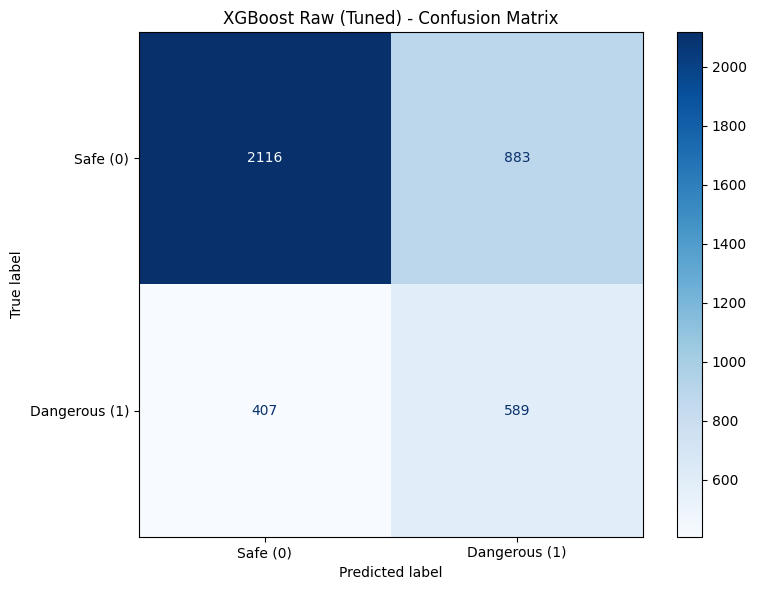

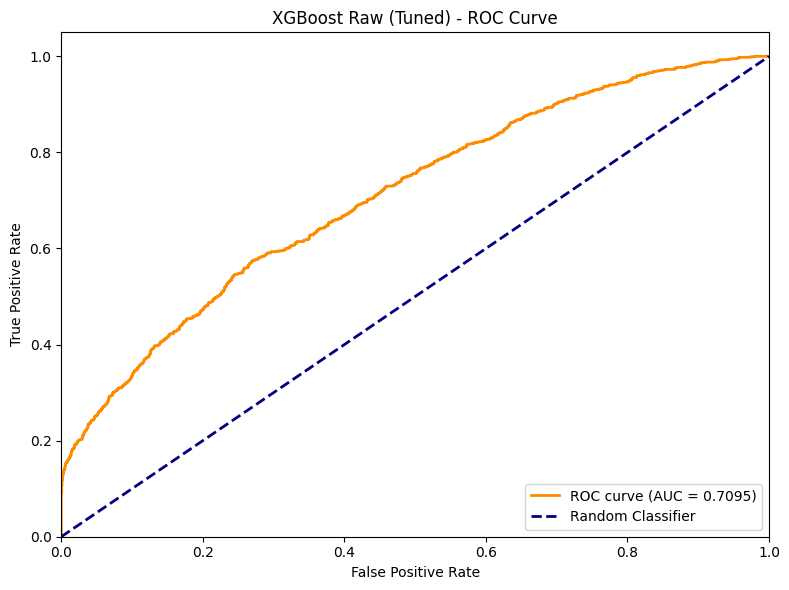

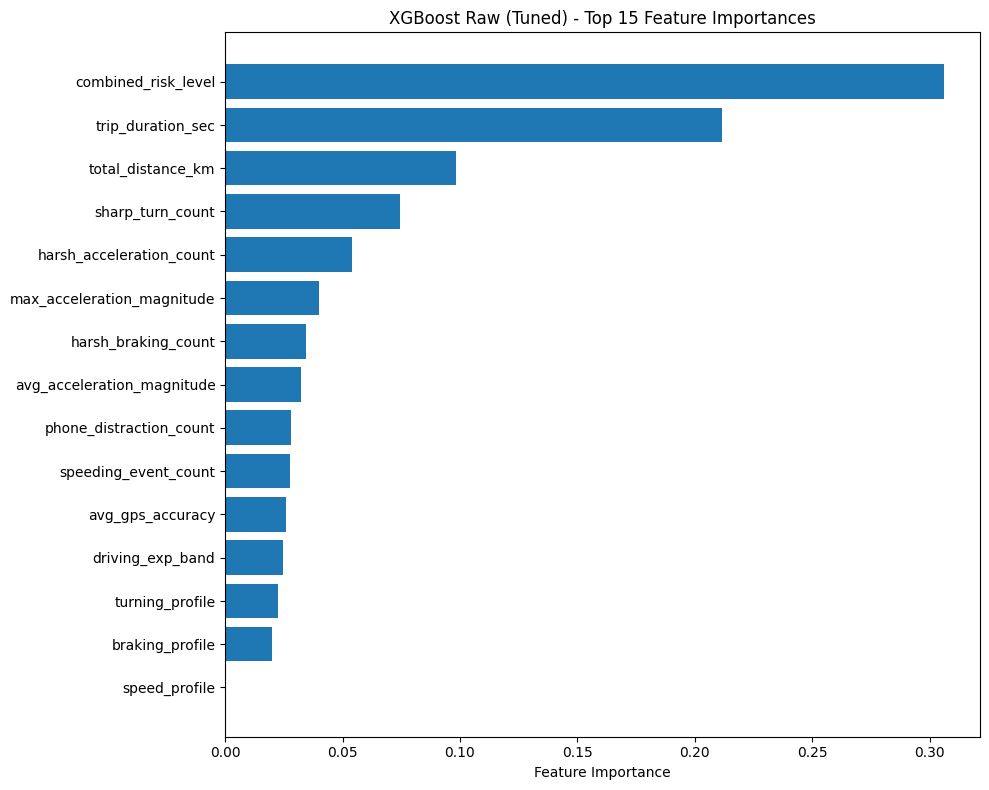

2026/02/02 00:25:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Tuned model logged to MLflow with ID: 6ddb6ea5ecf04e71b1806dc3b6425fc5
🏃 View run XGBoost_Raw_Tuned at: http://localhost:5000/#/experiments/25/runs/6ddb6ea5ecf04e71b1806dc3b6425fc5
🧪 View experiment at: http://localhost:5000/#/experiments/25


In [28]:
# Evaluate tuned model
xgb_tuned = random_search.best_estimator_

with mlflow.start_run(run_name="XGBoost_Raw_Tuned"):
    # Log best parameters
    mlflow.log_params(random_search.best_params_)
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("dataset", "raw_feature_engineered")
    mlflow.log_param("tuning_time_minutes", round(tuning_time/60, 2))
    
    # Evaluate tuned model
    metrics_tuned, y_pred_tuned, y_proba_tuned = evaluate_model(
        xgb_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="XGBoost Raw (Tuned)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_tuned['train_accuracy'],
        'test_accuracy': metrics_tuned['test_accuracy'],
        'train_f1': metrics_tuned['train_f1'],
        'test_f1': metrics_tuned['test_f1'],
        'precision': metrics_tuned['precision'],
        'recall': metrics_tuned['recall'],
        'roc_auc': metrics_tuned['roc_auc'],
        'overfit_gap': metrics_tuned['overfit_gap'],
        'cv_best_f1': random_search.best_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_tuned, "XGBoost Raw (Tuned)")
    mlflow.log_figure(fig_cm, "confusion_matrix_tuned.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_tuned, "XGBoost Raw (Tuned)")
    mlflow.log_figure(fig_roc, "roc_curve_tuned.png")
    plt.show()
    
    # Plot and log feature importance
    fig_fi = plot_feature_importance(xgb_tuned, X_train_scaled.columns.tolist(), top_n=15, 
                                     model_name="XGBoost Raw (Tuned)")
    mlflow.log_figure(fig_fi, "feature_importance_tuned.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.xgboost.log_model(xgb_tuned, "model", signature=signature)
    
    print(f"\n✅ Tuned model logged to MLflow with ID: {mlflow.active_run().info.run_id}")

---
## 10. Model Comparison Summary

In [29]:
# Summary comparison of all models
comparison_df = pd.DataFrame({
    'Model': ['XGBoost Raw (No Reg)', 'XGBoost Raw (Regularized)', 'XGBoost Raw (Tuned)'],
    'Train F1': [metrics_noreg['train_f1'], metrics_reg['train_f1'], metrics_tuned['train_f1']],
    'Test F1': [metrics_noreg['test_f1'], metrics_reg['test_f1'], metrics_tuned['test_f1']],
    'Precision': [metrics_noreg['precision'], metrics_reg['precision'], metrics_tuned['precision']],
    'Recall': [metrics_noreg['recall'], metrics_reg['recall'], metrics_tuned['recall']],
    'ROC-AUC': [metrics_noreg['roc_auc'], metrics_reg['roc_auc'], metrics_tuned['roc_auc']],
    'Overfit Gap': [metrics_noreg['overfit_gap'], metrics_reg['overfit_gap'], metrics_tuned['overfit_gap']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY (Raw Feature-Engineered Data)")
print("="*80)
print(comparison_df.to_string(index=False))

# Highlight best model
best_idx = comparison_df['Test F1'].idxmax()
print(f"\n🏆 Best Model by Test F1: {comparison_df.loc[best_idx, 'Model']} (F1: {comparison_df.loc[best_idx, 'Test F1']:.4f})")


MODEL COMPARISON SUMMARY (Raw Feature-Engineered Data)
                    Model  Train F1  Test F1  Precision   Recall  ROC-AUC  Overfit Gap
     XGBoost Raw (No Reg)  0.891532 0.435031   0.413575 0.458835 0.678119     0.456501
XGBoost Raw (Regularized)  0.639430 0.450292   0.385551 0.541165 0.698445     0.189137
      XGBoost Raw (Tuned)  0.520537 0.477310   0.400136 0.591365 0.709458     0.043227

🏆 Best Model by Test F1: XGBoost Raw (Tuned) (F1: 0.4773)


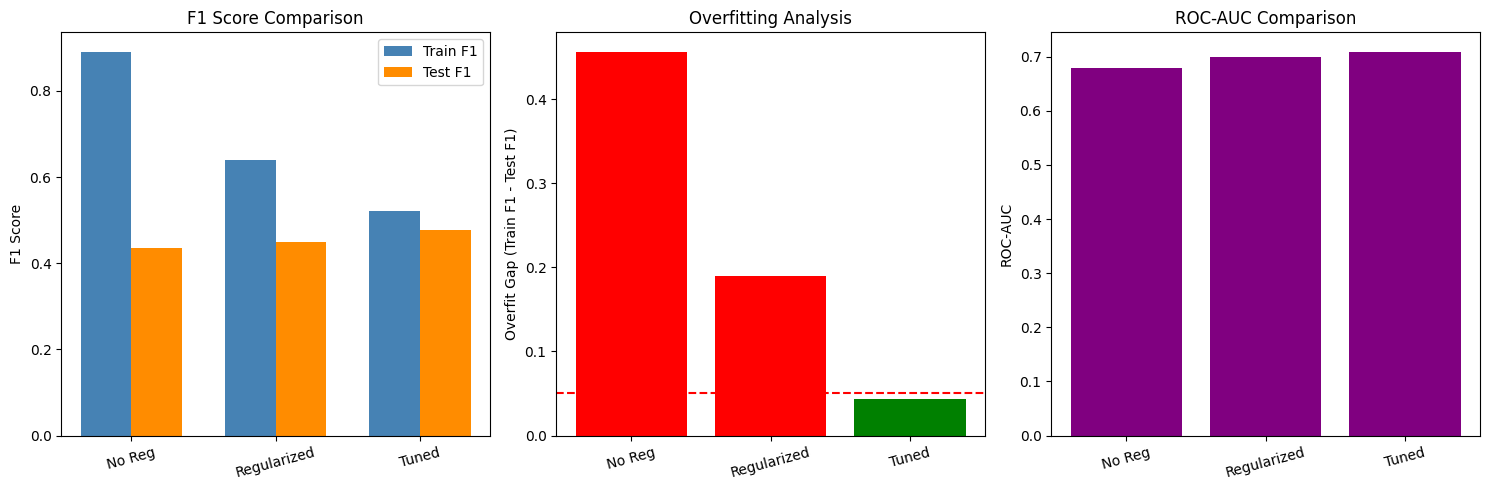

In [30]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1 Score comparison
x = range(len(comparison_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], comparison_df['Train F1'], width, label='Train F1', color='steelblue')
axes[0].bar([i + width/2 for i in x], comparison_df['Test F1'], width, label='Test F1', color='darkorange')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['No Reg', 'Regularized', 'Tuned'], rotation=15)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score Comparison')
axes[0].legend()

# Overfit gap
colors = ['red' if gap > 0.05 else 'green' for gap in comparison_df['Overfit Gap']]
axes[1].bar(x, comparison_df['Overfit Gap'], color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Reg', 'Regularized', 'Tuned'], rotation=15)
axes[1].set_ylabel('Overfit Gap (Train F1 - Test F1)')
axes[1].set_title('Overfitting Analysis')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Overfit Threshold')

# ROC-AUC comparison
axes[2].bar(x, comparison_df['ROC-AUC'], color='purple')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['No Reg', 'Regularized', 'Tuned'], rotation=15)
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('ROC-AUC Comparison')

plt.tight_layout()
plt.show()

---
## 11. Comparison with SMOTE-Balanced XGBoost

Compare results between raw data and SMOTE-balanced data training.

In [31]:
# Print comparison summary (fill in SMOTE results after running both notebooks)
print("="*80)
print("DATASET COMPARISON: Raw vs SMOTE-Balanced")
print("="*80)
print("\nRaw Feature-Engineered Data (This Notebook):")
print(f"  - Dataset size: {len(df)} samples")
print(f"  - Class imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"  - Best Test F1: {comparison_df['Test F1'].max():.4f}")
print(f"  - Best ROC-AUC: {comparison_df['ROC-AUC'].max():.4f}")

print("\nSMOTE-Balanced Data (xgboost_training_ablation.ipynb):")
print("  - Run that notebook and compare results manually")
print("  - Expected: Better minority class recall, potentially lower precision")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("- Raw data preserves original class distribution")
print("- SMOTE balances classes but may introduce synthetic artifacts")
print("- Compare precision-recall tradeoffs between approaches")
print("- Consider business requirements: is recall or precision more important?")

DATASET COMPARISON: Raw vs SMOTE-Balanced

Raw Feature-Engineered Data (This Notebook):
  - Dataset size: 19972 samples
  - Class imbalance ratio: 3.01:1
  - Best Test F1: 0.4773
  - Best ROC-AUC: 0.7095

SMOTE-Balanced Data (xgboost_training_ablation.ipynb):
  - Run that notebook and compare results manually
  - Expected: Better minority class recall, potentially lower precision

KEY INSIGHTS:
- Raw data preserves original class distribution
- SMOTE balances classes but may introduce synthetic artifacts
- Compare precision-recall tradeoffs between approaches
- Consider business requirements: is recall or precision more important?


---
## 12. Save Best Model

In [32]:
import joblib
import os

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Determine best model
models = {
    'noreg': (xgb_noreg, metrics_noreg),
    'reg': (xgb_reg, metrics_reg),
    'tuned': (xgb_tuned, metrics_tuned)
}

best_model_name = max(models.keys(), key=lambda k: models[k][1]['test_f1'])
best_model, best_metrics = models[best_model_name]

# Save the best model
model_path = os.path.join(models_dir, 'xgboost_raw_best_model.joblib')
joblib.dump(best_model, model_path)

# Save the scaler
scaler_path = os.path.join(models_dir, 'xgboost_raw_scaler.joblib')
joblib.dump(scaler, scaler_path)

# Save label encoders
encoders_path = os.path.join(models_dir, 'xgboost_raw_label_encoders.joblib')
joblib.dump(label_encoders, encoders_path)

print(f"Best model saved: {model_path}")
print(f"Scaler saved: {scaler_path}")
print(f"Label encoders saved: {encoders_path}")
print(f"\nBest Model: XGBoost Raw ({best_model_name})")
print(f"Test F1 Score: {best_metrics['test_f1']:.4f}")
print(f"Overfit Gap: {best_metrics['overfit_gap']:.4f}")

Best model saved: ../models\xgboost_raw_best_model.joblib
Scaler saved: ../models\xgboost_raw_scaler.joblib
Label encoders saved: ../models\xgboost_raw_label_encoders.joblib

Best Model: XGBoost Raw (tuned)
Test F1 Score: 0.4773
Overfit Gap: 0.0432


---
## Summary

This notebook trained XGBoost models on the **raw feature-engineered dataset** (`fact_trip_safety.csv`) for comparison with the SMOTE-balanced dataset.

### Key Differences from SMOTE Training:
1. **Dataset**: Uses original class distribution (imbalanced)
2. **Class Handling**: Uses `scale_pos_weight` instead of SMOTE oversampling
3. **Categorical Features**: Required label encoding for profile columns

### Models Trained:
1. **No Regularization (Baseline)**: High complexity model
2. **With Regularization**: Applied L1/L2 regularization and subsampling
3. **Tuned**: Hyperparameter optimization via RandomizedSearchCV

### Comparison Points:
- Compare Test F1, Precision, Recall between raw and SMOTE approaches
- Evaluate which approach better suits business requirements
- Consider deployment implications of each approach